# Creating a General Purpose Potential for Molecular Crystals - Part 8

This notebook is used to create a general purpose GAP potential for molecular crystals. The potential is built on PBE-D3 data from short PIMD simulations of 2238 different molecular crystals. Please note that it has a high (~150 GB) memory requirement to run fully.

In this part of the notebook: 
- Move to Rascaline 
- Determine speed increases using Rascaline

### Import modules, functions, and necessary raw data from parts 1, 2 and 3

In [2]:
#Import modules
from matplotlib import pylab as plt
from tqdm import tqdm
import itertools
from joblib import Parallel, delayed, parallel_backend

import pickle
import numpy as np
from numpy.random import RandomState
random_state = RandomState(0)
from sklearn import linear_model
import skcosmo.feature_selection
#from skcosmo.feature_selection import FPS
from skcosmo.sample_selection import PCovCUR, FPS
from skcosmo.preprocessing import StandardFlexibleScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import GroupKFold, cross_val_score
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from skopt.space import Real, Integer
from skopt.utils import use_named_args
from skopt import gp_minimize, callbacks, dump, load
from skopt.callbacks import CheckpointSaver
from skopt.plots import plot_convergence, plot_objective

import ase
from ase.io import read, write
from ase.build import make_supercell
from ase.visualize import view
import numpy as np
# If installed -- not essential, though
try:
    from tqdm.notebook import tqdm
except ImportError:
    tqdm = (lambda i, **kwargs: i)

from time import time, sleep

from rascal.models import KRR
from rascal.utils import dump_obj, load_obj

from rascal.models import Kernel, train_gap_model, compute_KNM
from rascal.representations import SphericalInvariants
from rascal.neighbourlist.structure_manager import mask_center_atoms_by_species
from rascal.utils import from_dict, to_dict, CURFilter, FPSFilter, dump_obj, load_obj
from rascal.utils import get_score, get_optimal_radial_basis_hypers
from rascal.utils.io import load_json, dump_json

In [3]:
#Define functions
def do_fps(x, d=0):
    """
    Function for performing farthest-point-sampling for a given feature matrix.
    d gives the number of farthest-point-sampled feature vectors that will be outputted. 
    If d==0, the entire set will be FPS-sorted.
    Returns the FPS-sorted IDs, as well as the FPS distances.
    """
    if d == 0 : d = len(x)
    n = len(x)
    iy = np.zeros(d, int)
    # faster evaluation of Euclidean distance
    n2 = np.sum(x**2,axis=1)
    iy[0] = 0
    dl = n2 + n2[iy[0]] - 2* np.dot(x, x[iy[0]])
    dss = []
    for i in range(1,d):
        iy[i] = np.argmax(dl)
        nd = n2 + n2[iy[i]] - 2*np.dot(x,x[iy[i]])
        dl = np.minimum(dl, nd)
        dss.append(max(dl))
    return iy,dss

def get_forces(frames):
    frc = np.zeros((np.sum([len(frm) for frm in frames]),3))
    iat = 0
    for ifrm,frm in enumerate(frames):
        frc[iat:iat+len(frm)] = frm.get_array('forces') 
        iat += len(frm)
    return frc

def get_features(atoms_objects, batch_size=1000, progress_bar=True):
    '''Get average feature vectors for each structure in a list of atoms objects. 
        This requires soap to be set.
    '''
    struct_feat=[] #create empty feature vector of n_structures x n_features
    got_frame = False
    for frm in atoms_objects:
        if got_frame == False: 
            if all(sp in frm.get_atomic_numbers() for sp in [1,6,7,8]) == True:
                all_species = frm
                got_frame = True
    for i in tqdm(range(int(len(atoms_objects)/batch_size+0.9999)), disable = not progress_bar): #Get feature vectors in batches of 1000
        for frm in atoms_objects[i*batch_size:(i+1)*batch_size]:
            frm.wrap(eps=1e-13) #wrap atoms in unit cell
        frames=[all_species.copy()] #add initial frame with all species
        frames.extend(atoms_objects[i*batch_size:(i+1)*batch_size]) #extend initial frame with frames of batch
        manager = soap.transform(frames) #calculate soap features for all structures in batch
        env_feat_batch = manager.get_features(soap)[len(all_species):] #get feature vectors for all structures in batch
        # (having removed the initial frame)
        atom_counter=0 #count atoms
        for ifrm,frm in enumerate(atoms_objects[i*batch_size:(i+1)*batch_size]): #iterate over frames in batch
            nat=len(frm) #count atoms in frame
            struct_feat.append(np.mean(env_feat_batch[atom_counter:atom_counter+nat],axis=0)) #average vectors
            # for atoms in the same frame. Done by averaging vectors between atom_counter and atom_counter + nat
            atom_counter+=nat #add atoms to counter
    struct_feat_array=np.asarray(struct_feat)
    return struct_feat_array

def get_features_parallel(atoms_objects, bsize=1000, n_cores = 4):
    '''Get average feature vectors for each structure in a list of atoms objects. 
        Do this in parallel
    '''
    blocks = []
    for iblk, blk in enumerate(range(0, len(atoms_objects), bsize)):
        blocks.append(atoms_objects[iblk*bsize:(iblk+1)*bsize])
    with parallel_backend(backend="loky"):
        results = Parallel(n_jobs=n_cores)(delayed(get_features)(frames, batch_size=10000, 
                                                                 progress_bar=False) for frames in blocks)

    return np.concatenate(results)

def predict_batched(frames, ml_model):
    man_pred = soap.transform(frames)
    return ml_model.predict(man_pred)

In [4]:
#Import raw data
train_set = np.load('raw_data/CSD-10k_train_set.npy', allow_pickle=True)
val_set = np.load('raw_data/CSD-10k_val_set.npy', allow_pickle=True)
test_set = np.load('raw_data/CSD-10k_test_set.npy', allow_pickle=True)
X_train = np.load('raw_data/X_train.npy') 
y_train = np.load('raw_data/y_train.npy')
X_val = np.load('raw_data/X_val.npy') 
y_val = np.load('raw_data/y_val.npy')
X_test = np.load('raw_data/X_test.npy') 
y_test = np.load('raw_data/y_test.npy')
X_train_fps = np.load('raw_data/X_train_fps.npy')
y_train_fps = np.load('raw_data/y_train_fps.npy')
fps_ids = np.load('raw_data/CSD-10k_train_set_FPS_ids.npy')
fps_dist = np.load('raw_data/CSD-10k_train_set_FPS_dist.npy')
with open('raw_data/mlr.pkl', 'rb') as mlr_file:
    mlr = pickle.load(mlr_file)
initial_train_set = np.load('raw_data/initial_train_set_4pc.npy', allow_pickle=True)
train_set_FPS = np.load('model_data/train_set_FPS.npy', allow_pickle=True)

/home/vprincip/code/miniconda3/envs/genshift/lib/python3.10/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator Ridge from version 1.1.0rc1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(


### Compute necessary data and define SOAP

In [5]:
#Compute training, validation and testing data
#Get training data for the FPS-sorted training set
ytF = []
for ifrm, frm in enumerate(train_set_FPS):
    ytF.append(frm.info['energy'])
ytrain_FPS = np.array(ytF)

#Get true energies and forces for validation set
yvt = []
fvt = []

for frm in val_set:
    yvt.append(frm.info['energy'])
    fvt.append(frm.get_array('forces'))

yval_true = np.array(yvt)
fval_true = np.concatenate(fvt)

#Get true energies and forces for test set
ytt = []
ftt = []

for frm in test_set:
    ytt.append(frm.info['energy'])
    ftt.append(frm.get_array('forces'))

ytest_true = np.array(ytt)
ftest_true = np.concatenate(ftt)

#get dressed atom energies for reduced training set
y_dressed = {}
for i,j in enumerate([1,6,7,8]):
    y_dressed[j] = mlr.coef_[i]

In [6]:
#Define hyperparameters and SOAP
zeta=3
hypers = dict(soap_type="PowerSpectrum",
              interaction_cutoff=6, #cutoff distance in angstroms
              max_radial=9, #no. of radial basis functions
              max_angular=6, #no. of angular basis functions
              gaussian_sigma_constant=0.4, #sigma width (i.e. amount of 'smearing')
              gaussian_sigma_type="Constant",
              cutoff_function_type="RadialScaling",
              cutoff_smooth_width=0.5,
              cutoff_function_parameters=
                    dict(
                            rate=1,
                            scale=2,
                            exponent=4
                        ),
              radial_basis="GTO",
              normalize=True,
              optimization=
                    dict(
                            Spline=dict(
                               accuracy=1.0e-05
                            )
                        ),
              compute_gradients=False 
              )
soap = SphericalInvariants(**hypers) #redefine soap with new parameters

## Check % RMSE for energies and forces using one of the best models

In [13]:
#Define hyperparameters and SOAP
zeta=3
hypers = dict(soap_type="PowerSpectrum",
              interaction_cutoff=6, #cutoff distance in angstroms
              max_radial=9, #no. of radial basis functions
              max_angular=6, #no. of angular basis functions
              gaussian_sigma_constant=0.4, #sigma width (i.e. amount of 'smearing')
              gaussian_sigma_type="Constant",
              cutoff_function_type="RadialScaling",
              cutoff_smooth_width=0.5,
              cutoff_function_parameters=
                    dict(
                            rate=1,
                            scale=2,
                            exponent=4
                        ),
              radial_basis="GTO",
              normalize=True,
              optimization=
                    dict(
                            Spline=dict(
                               accuracy=1.0e-05
                            )
                        ),
              compute_gradients=False 
              )
soap = SphericalInvariants(**hypers) #redefine soap with new parameters

In [15]:
#Define kernel and redefine hypers 
hypers["compute_gradients"] = True #we want to compute gradients (forces) for the kernel
soap = SphericalInvariants(**hypers)
kernel = Kernel(soap, name='GAP', zeta=zeta, target_type='Structure', kernel_type='Sparse') #Define Kernel

In [8]:
#Reload model
full_model = load_obj('raw_data/full_GAP_model_FPS_0.055_3.25.json')

In [16]:
#predict energies and forces for validation set
npred=100
yvp = []
fvp = []

for ifrm, frm in enumerate(tqdm(val_set[:npred], desc = "Making predictions for validation set...", leave=False)):
    manager_val = soap.transform(frm)
    yvp.append(full_model.predict(manager_val))
    fvp.append(full_model.predict_forces(manager_val))

yval_pred = np.array(yvp).flatten()
fval_pred = np.concatenate(fvp)


Making predictions for validation set...:   0%|          | 0/100 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Forces (ev/$\\AA$)')

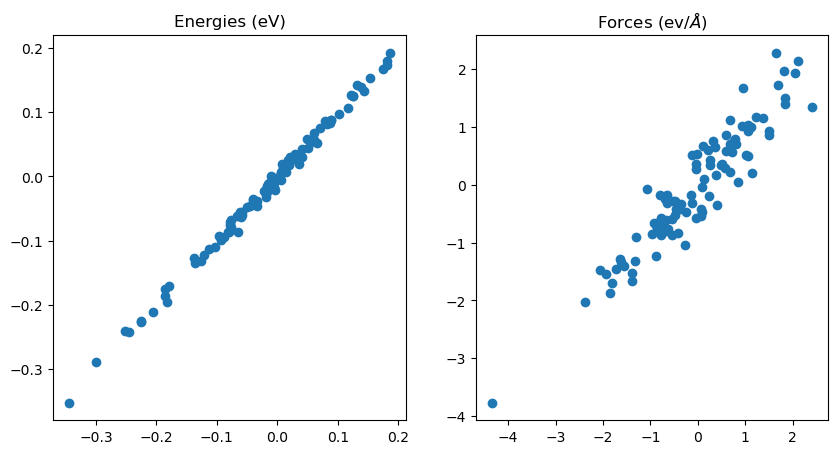

In [24]:
#Plot predicted vs. actual energies and forces
f,p = plt.subplots(1,2, figsize = (10, 5))
p[0].scatter((y_val[:npred] - mlr.predict(X_val[:npred]))/np.sum(X_val[:npred],axis=1),
             (yval_pred[:npred] - mlr.predict(X_val[:npred]))/np.sum(X_val[:npred],axis=1))
p[0].set_title('Energies (eV)')
p[0].set()
p[1].scatter(fval_true.flatten()[:npred], fval_pred.flatten()[:npred])
p[1].set_title(r'Forces (ev/$\AA$)')

In [25]:
rmse_energy = np.sqrt(np.mean(((yval_true[:npred] - mlr.predict(X_val[:npred]))/np.sum(X_val[:npred],axis=1) - (yval_pred[:npred] - mlr.predict(X_val[:npred]))/np.sum(X_val[:npred],axis=1))**2))

In [29]:
atoms = 0
for frm in val_set[:100]:
    atoms += len(frm)

In [32]:
fval_true[:atoms]

array([[-0.36053294,  0.59856824,  0.22081251],
       [-0.68784723,  0.2296026 , -0.85439301],
       [-0.69213583, -0.48373609,  0.07288255],
       ...,
       [-0.09632947, -0.6225155 , -1.0941638 ],
       [ 0.13961193, -0.17128124,  0.084687  ],
       [ 0.0174218 , -0.36512905, -0.65838753]])

In [54]:
rmse_forces = np.sqrt(np.mean((fval_true[:atoms].flatten() - fval_pred.flatten())**2))

In [34]:
print(rmse_energy, rmse_forces)

0.007087017974018674 0.3793270908699653


In [45]:
percentage = np.sqrt(np.mean(((fval_true[:atoms].flatten() - fval_pred.flatten())/fval_true[:atoms].flatten())**2))*100

In [46]:
np.mean(np.square((fval_true[:atoms].flatten() - fval_pred.flatten())/fval_true[:atoms].flatten()))

6576733.919546054

In [52]:
squared = (((fval_true[:atoms].flatten() - fval_pred.flatten())/fval_true[:atoms].flatten())**2)

In [53]:
np.sort(squared)

array([1.36401893e-10, 1.20376810e-09, 4.46682020e-09, ...,
       1.13525756e+10, 1.90359728e+10, 1.22197356e+11])

In [55]:
rmse_forces

0.3793270908699653

In [56]:
rms_forces = np.sqrt(np.mean(fval_true[:atoms]**2))

In [63]:
print(f"% RMSE for forces: {rmse_forces/rms_forces * 100} %")

% RMSE for forces: 46.05104690535202 %


In [60]:
rms_energy = np.sqrt(np.mean(((y_val[:npred] - mlr.predict(X_val[:npred]))/np.sum(X_val[:npred],axis=1))**2))

In [67]:
print(f"% RMSE for energies: {(rmse_energy/rms_energy)*100} %")

% RMSE for energies: 6.565460586984992 %


## Start using Rascaline
Let's start using Rascaline and compare its feature computation time with the older Rascal.

We will compare computation time with Rascal for gradients too.

### Compare speed without gradients

In [79]:
#Define Rascaline-style and SOAP hypers
zeta=3
hypers = dict(soap_type='PowerSpectrum',
              interaction_cutoff=6, #cutoff distance in angstroms
              max_radial=9, #no. of radial basis functions
              max_angular=6, #no. of angular basis functions
              gaussian_sigma_constant=0.4, #sigma width (i.e. amount of 'smearing')
              gaussian_sigma_type="Constant",
              cutoff_function_type="RadialScaling",
              cutoff_smooth_width=0.5,
              cutoff_function_parameters=
                    dict(
                            rate=1,
                            scale=2,
                            exponent=4
                        ),
              radial_basis="GTO",
              normalize=False,
              optimization=
                    dict(
                            Spline=dict(
                               accuracy=1.0e-05
                            )
                        ),
              compute_gradients=False 
              )
soap = SphericalInvariants(**hypers) #redefine soap with new parameters

In [81]:
# Compute features using rascal
start=time()
for frm in tqdm(train_set[:100]):
    soap.transform(frm)
print(f"Time taken: {np.round(time()-start, 4)}s")

  0%|          | 0/100 [00:00<?, ?it/s]

Time taken: 1.7594s


In [82]:
from rascaline import SoapPowerSpectrum

HYPER_PARAMETERS = {
    "cutoff": 6,
    "max_radial": 9,
    "max_angular": 6,
    "atomic_gaussian_width": 0.4,
    "center_atom_weight": 1.0,
    "radial_basis": {
        "Gto": {"spline_accuracy": 1e-5},
    },
    "cutoff_function": {
        "ShiftedCosine": {"width": 0.5},
        
    },
    "radial_scaling":{
        "Willatt2018": {"exponent": 4, "rate": 1, "scale": 2},
    },
}

calculator = SoapPowerSpectrum(**HYPER_PARAMETERS)

In [83]:
# Compute features using rascaline
start=time()
for frm in tqdm(train_set[:100]):
    calculator.compute(frm)
print(f"Time taken: {np.round(time()-start, 4)}s")

  0%|          | 0/100 [00:00<?, ?it/s]

Time taken: 5.4109s


Seems like Rascaline is about a third the speed of Rascal when not computing gradients. Let's see how they compare when computing gradients too...

### Compare speed with gradients

In [84]:
hypers["compute_gradients"] = True
soap = SphericalInvariants(**hypers)

In [85]:
# Compute features using rascal
start=time()
for frm in tqdm(train_set[:10]):
    soap.transform(frm)
print(f"Time taken: {np.round(time()-start, 4)}s")

  0%|          | 0/10 [00:00<?, ?it/s]

Time taken: 7.2975s


In [86]:
# Compute features using rascaline
start=time()
for frm in tqdm(train_set[:10]):
    calculator.compute(frm, gradients=["positions"])
print(f"Time taken: {np.round(time()-start, 4)}s")

  0%|          | 0/10 [00:00<?, ?it/s]

Time taken: 3.7109s


The true benefit of using rascaline becomes clear when computing gradients, which is about twice as fast!

In [87]:
## Function for normalizing a TensorMap
def normalize(descriptor):
    blocks = []
    for _, block in descriptor:
        # only deal with invariants for now
        assert len(block.components) == 0
        assert len(block.values.shape) == 2

        norm = ops.norm(block.values, axis=1)
        normalized_values = block.values / norm[:, None]

        new_block = TensorBlock(
            values=normalized_values,
            samples=block.samples,
            components=[],
            properties=block.properties,
        )

        if block.has_gradient("positions"):
            gradient = block.gradient("positions")

            gradient_data = gradient.data / norm[gradient.samples["sample"], None, None]

            # gradient of x_i = X_i / N_i is given by
            # 1 / N_i \grad X_i - x_i [x_i @ 1 / N_i \grad X_i]
            for sample_i, (sample, _, _) in enumerate(gradient.samples):
                dot = gradient_data[sample_i] @ normalized_values[sample].T

                gradient_data[sample_i, 0, :] -= dot[0] * normalized_values[sample, :]
                gradient_data[sample_i, 1, :] -= dot[1] * normalized_values[sample, :]
                gradient_data[sample_i, 2, :] -= dot[2] * normalized_values[sample, :]

            new_block.add_gradient(
                "positions", gradient_data, gradient.samples, gradient.components
            )

        blocks.append(new_block)

    return TensorMap(descriptor.keys, blocks)

## Get True test set energies and forces for an original model

In [12]:
#Define hyperparameters and SOAP
zeta=3
hypers = dict(soap_type="PowerSpectrum",
              interaction_cutoff=4, #cutoff distance in angstroms
              max_radial=6, #no. of radial basis functions
              max_angular=4, #no. of angular basis functions
              gaussian_sigma_constant=0.4, #sigma width (i.e. amount of 'smearing')
              gaussian_sigma_type="Constant",
              cutoff_function_type="RadialScaling",
              cutoff_smooth_width=0.5,
              cutoff_function_parameters=
                    dict(
                            rate=1,
                            scale=2,
                            exponent=4
                        ),
              radial_basis="GTO",
              normalize=True,
              optimization=
                    dict(
                            Spline=dict(
                               accuracy=1.0e-05
                            )
                        ),
              compute_gradients=True 
              )
soap = SphericalInvariants(**hypers) #redefine soap with new parameters

In [8]:
full_model = load_obj('model_data/full_GAP_model_20k_2500ps_0.01_0.1.json')

In [9]:
with open('raw_data/CSD-1k_hcno_w_DFTB.pickle', 'rb') as f:
    csd_1k = pickle.load(f)

In [10]:
X_1k = np.zeros((len(csd_1k), 4), dtype=int); y_1k = np.zeros(len(csd_1k), dtype=float)
f_1k = np.zeros((sum([len(frm) for frm in csd_1k]),3), dtype=float)

force_counter=0
for ifrm, frm in enumerate(csd_1k):
    X_1k[ifrm] = [len(np.where(frm.get_atomic_numbers() == sp)[0]) for sp in [1,6,7,8]]
    y_1k[ifrm] = frm.info['PBE-D2_energy']
    for iforces, forces in enumerate(frm.arrays['PBE-D2_forces']):
        f_1k[force_counter] = forces
        force_counter += 1

In [13]:
#predict energies and forces for test set
npred=1000
ytp = []
ftp = []

for frm in tqdm(csd_1k[:npred], desc = "Making predictions for true test set...", leave=False):
    manager_test = soap.transform(frm)
    ytp.append(full_model.predict(manager_test))
    ftp.append(full_model.predict_forces(manager_test))

ytest_pred = np.array(ytp).flatten()
ftest_pred = np.concatenate(ftp)

Making predictions for true test set...:   0%|          | 0/1000 [00:00<?, ?it/s]

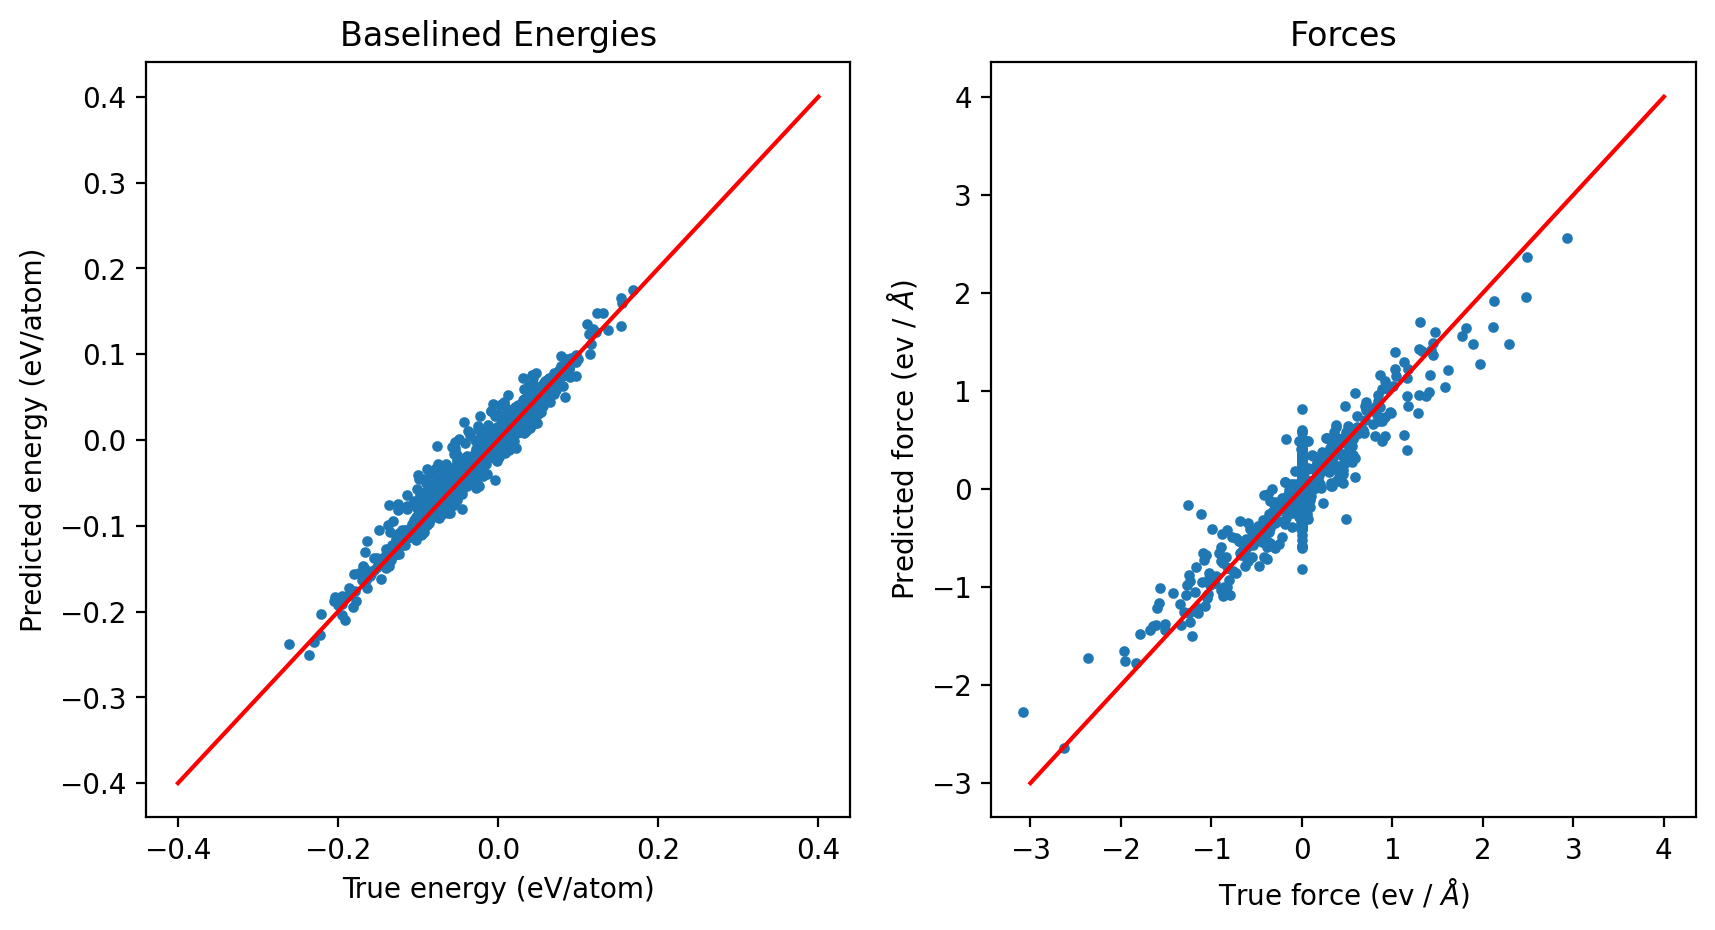

In [16]:
#Plot predicted vs. actual energies and forces
f,p = plt.subplots(1,2, figsize = (10, 5), dpi=200)
p[0].scatter((y_1k[:npred] - mlr.predict(X_1k[:npred]))/np.sum(X_1k[:npred],axis=1),
             (ytest_pred[:npred] - mlr.predict(X_1k[:npred]))/np.sum(X_1k[:npred],axis=1), s=8)
p[0].plot([-0.4,0.4],[-0.4, 0.4], color='red')
p[0].set_title(r'Baselined Energies')
p[0].set_xlabel('True energy (eV/atom)')
p[0].set_ylabel('Predicted energy (eV/atom)')
p[1].scatter(f_1k.flatten()[:npred], ftest_pred.flatten()[:npred], s=8)
p[1].plot([-3,4],[-3, 4], color='red')
p[1].set_title(r'Forces')
p[1].set_xlabel('True force (ev / $\AA$)')
p[1].set_ylabel('Predicted force (ev / $\AA$)')
plt.savefig('figures/true_test_set_direct_full_GAP_model_20k_2500ps_0.01_0.1.png')

In [17]:
rmse_energy = np.sqrt(np.mean(
    ((y_1k[:npred] - mlr.predict(X_1k[:npred]))/np.sum(X_1k[:npred],axis=1) 
     - (ytest_pred[:npred] - mlr.predict(X_1k[:npred]))/np.sum(X_1k[:npred],axis=1))**2))

In [18]:
rmse_forces = np.sqrt(np.mean((f_1k.flatten()[:npred] - ftest_pred.flatten()[:npred])**2))

In [19]:
print("RMSE energy: ", np.round(rmse_energy, 8)*1000, "meV/atom")
print("RMSE forces: ", np.round(rmse_forces, 5)*1000, "meV/Angstrom")

RMSE energy:  14.88451 meV/atom
RMSE forces:  196.58999999999997 meV/Angstrom


## Test on a second original model

In [20]:
full_model = load_obj('model_data/full_GAP_model_FPS_0.055_3.25.json')

In [22]:
#Define hyperparameters and SOAP
zeta=3
hypers = dict(soap_type="PowerSpectrum",
              interaction_cutoff=6, #cutoff distance in angstroms
              max_radial=9, #no. of radial basis functions
              max_angular=6, #no. of angular basis functions
              gaussian_sigma_constant=0.4, #sigma width (i.e. amount of 'smearing')
              gaussian_sigma_type="Constant",
              cutoff_function_type="RadialScaling",
              cutoff_smooth_width=0.5,
              cutoff_function_parameters=
                    dict(
                            rate=1,
                            scale=2,
                            exponent=4
                        ),
              radial_basis="GTO",
              normalize=True,
              optimization=
                    dict(
                            Spline=dict(
                               accuracy=1.0e-05
                            )
                        ),
              compute_gradients=True 
              )
soap = SphericalInvariants(**hypers) #redefine soap with new parameters

In [25]:
#predict energies and forces for test set
npred=1000
ytp = []
ftp = []

for frm in tqdm(csd_1k[:npred], desc = "Making predictions for true test set...", leave=False):
    manager_test = soap.transform(frm)
    ytp.append(full_model.predict(manager_test))
    ftp.append(full_model.predict_forces(manager_test))

ytest_pred_2 = np.array(ytp).flatten()
ftest_pred_2 = np.concatenate(ftp)

Making predictions for true test set...:   0%|          | 0/1000 [00:00<?, ?it/s]

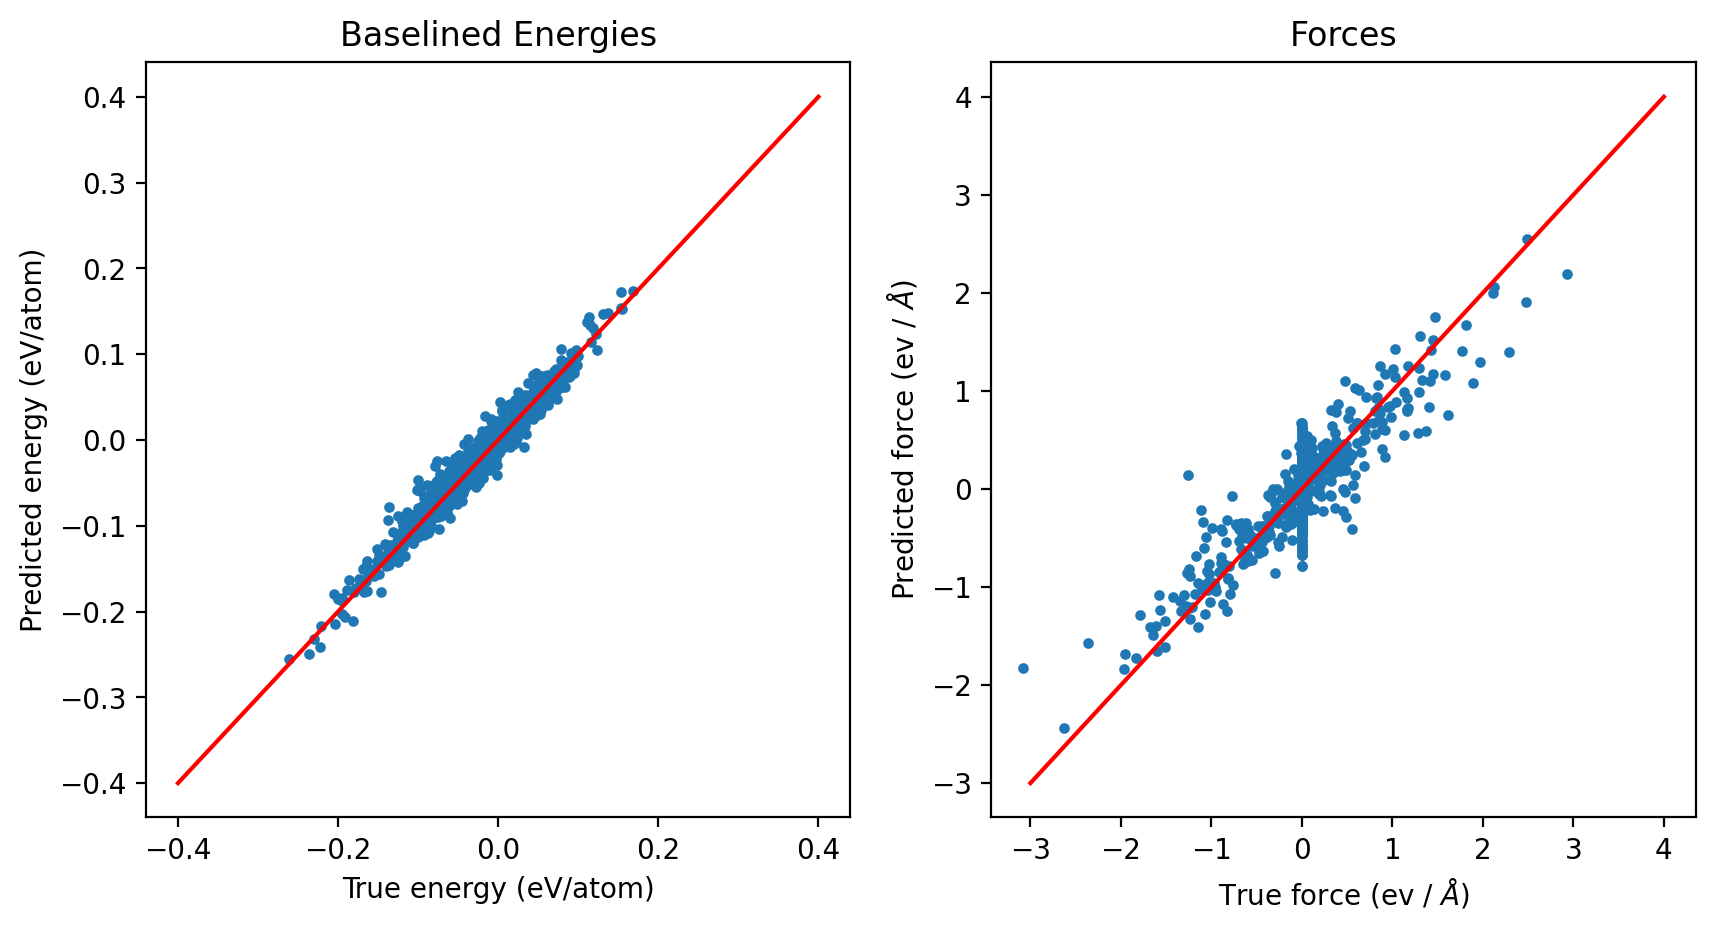

In [26]:
#Plot predicted vs. actual energies and forces
f,p = plt.subplots(1,2, figsize = (10, 5), dpi=200)
p[0].scatter((y_1k[:npred] - mlr.predict(X_1k[:npred]))/np.sum(X_1k[:npred],axis=1),
             (ytest_pred_2[:npred] - mlr.predict(X_1k[:npred]))/np.sum(X_1k[:npred],axis=1), s=8)
p[0].plot([-0.4,0.4],[-0.4, 0.4], color='red')
p[0].set_title(r'Energies')
p[0].set_xlabel('True energy (eV/atom)')
p[0].set_ylabel('Predicted energy (eV/atom)')
p[1].scatter(f_1k.flatten()[:npred], ftest_pred_2.flatten()[:npred], s=8)
p[1].plot([-3,4],[-3, 4], color='red')
p[1].set_title(r'Forces')
p[1].set_xlabel('True force (ev / $\AA$)')
p[1].set_ylabel('Predicted force (ev / $\AA$)')
plt.savefig('figures/true_test_set_direct_full_GAP_model_FPS_0.055_3.25.png')

In [27]:
rmse_energy = np.sqrt(np.mean(
    ((y_1k[:npred] - mlr.predict(X_1k[:npred]))/np.sum(X_1k[:npred],axis=1) 
     - (ytest_pred_2[:npred] - mlr.predict(X_1k[:npred]))/np.sum(X_1k[:npred],axis=1))**2))

In [28]:
rmse_forces = np.sqrt(np.mean((f_1k.flatten()[:npred] - ftest_pred_2.flatten()[:npred])**2))

In [29]:
print("RMSE energy: ", np.round(rmse_energy, 8)*1000, "meV/atom")
print("RMSE forces: ", np.round(rmse_forces, 5)*1000, "meV/Angstrom")

RMSE energy:  12.90125 meV/atom
RMSE forces:  249.35 meV/Angstrom


### Get validation set values

In [30]:
#predict energies and forces for validation set
npred=1000
ytp = []
ftp = []

for frm in tqdm(val_set[:npred], desc = "Making predictions for validation set...", leave=False):
    manager_test = soap.transform(frm)
    ytp.append(full_model.predict(manager_test))
    ftp.append(full_model.predict_forces(manager_test))

yval_pred_2 = np.array(ytp).flatten()
fval_pred_2 = np.concatenate(ftp)

Making predictions for validation set...:   0%|          | 0/1000 [00:00<?, ?it/s]

In [33]:
#get validation forces
f_val = np.zeros((np.sum([len(frm) for frm in val_set]), 3), dtype=float)
counter=0
for frm in val_set:
    f_val[counter:counter+len(frm)] = frm.arrays['forces']
    counter += len(frm)

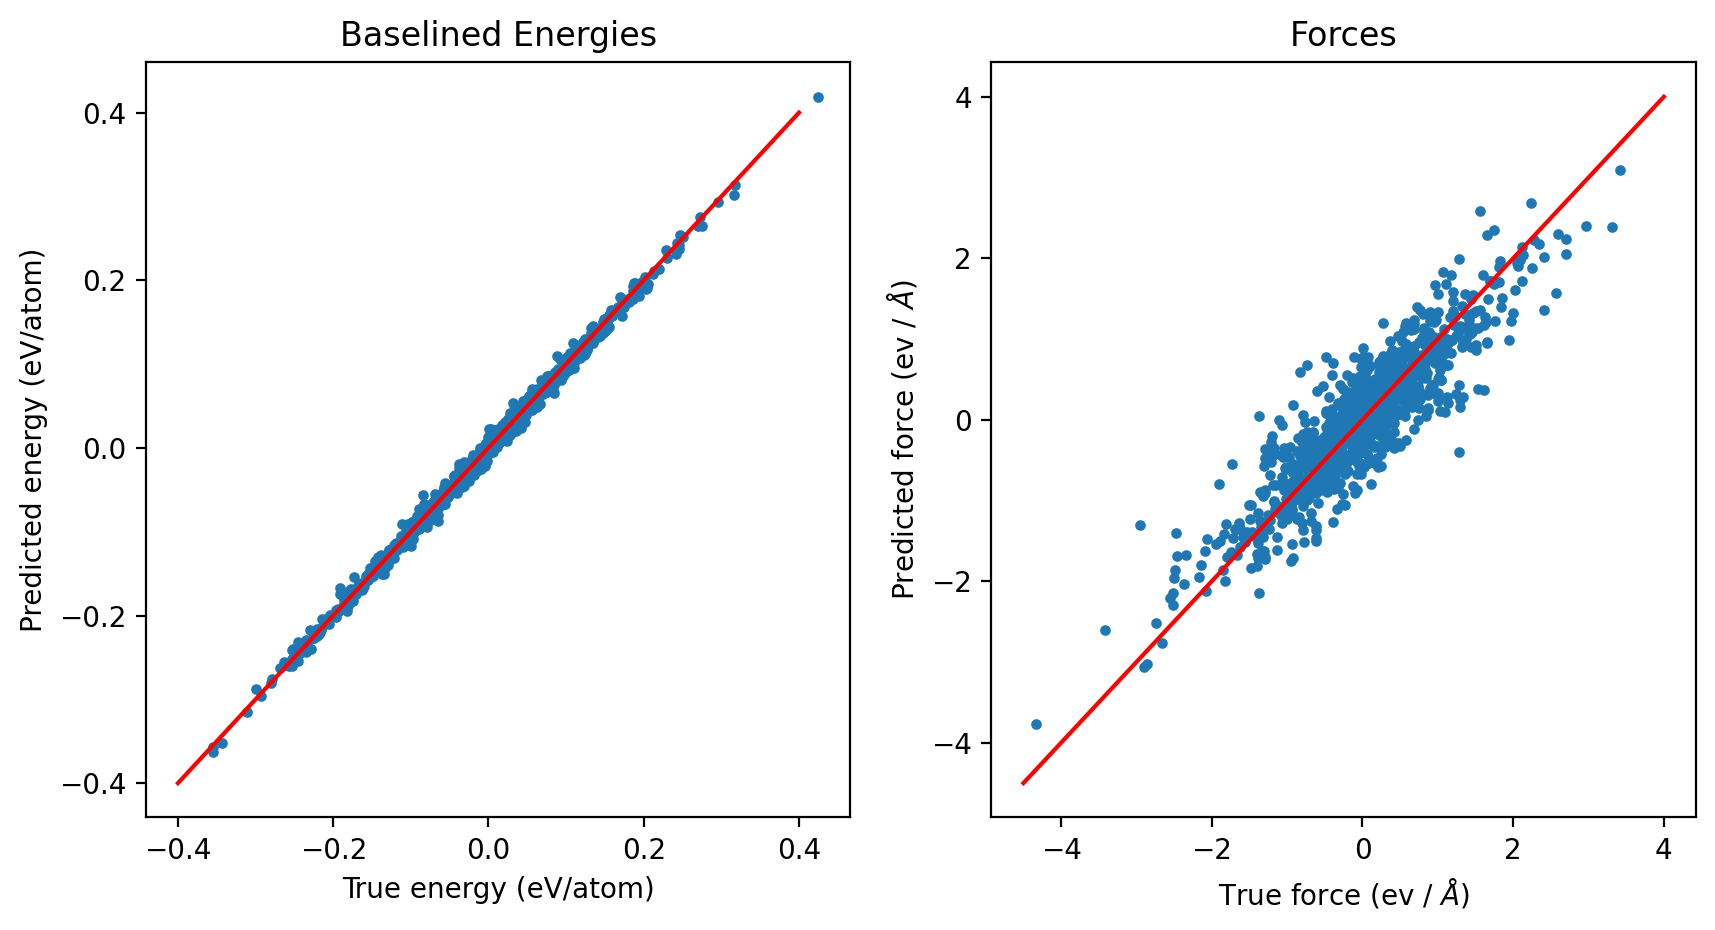

In [37]:
#Plot predicted vs. actual energies and forces
f,p = plt.subplots(1,2, figsize = (10, 5), dpi=200)
p[0].scatter((y_val[:npred] - mlr.predict(X_val[:npred]))/np.sum(X_val[:npred],axis=1),
             (yval_pred_2[:npred] - mlr.predict(X_val[:npred]))/np.sum(X_val[:npred],axis=1), s=8)
p[0].plot([-0.4,0.4],[-0.4, 0.4], color='red')
p[0].set_title(r'Baselined Energies')
p[0].set_xlabel('True energy (eV/atom)')
p[0].set_ylabel('Predicted energy (eV/atom)')
p[1].scatter(f_val.flatten()[:npred], fval_pred_2.flatten()[:npred], s=8)
p[1].plot([-4.5,4],[-4.5, 4], color='red')
p[1].set_title(r'Forces')
p[1].set_xlabel('True force (ev / $\AA$)')
p[1].set_ylabel('Predicted force (ev / $\AA$)')
plt.savefig('figures/val_set_direct_full_GAP_model_FPS_0.055_3.25.png')

In [38]:
rmse_energy = np.sqrt(np.mean(
    ((y_val[:npred] - mlr.predict(X_val[:npred]))/np.sum(X_val[:npred],axis=1) 
     - (yval_pred_2[:npred] - mlr.predict(X_val[:npred]))/np.sum(X_val[:npred],axis=1))**2))

In [39]:
rmse_forces = np.sqrt(np.mean((f_val.flatten()[:npred] - fval_pred_2.flatten()[:npred])**2))

In [40]:
print("RMSE energy: ", np.round(rmse_energy, 8)*1000, "meV/atom")
print("RMSE forces: ", np.round(rmse_forces, 5)*1000, "meV/Angstrom")

RMSE energy:  6.50577 meV/atom
RMSE forces:  397.32 meV/Angstrom


## Plot both test set and val set

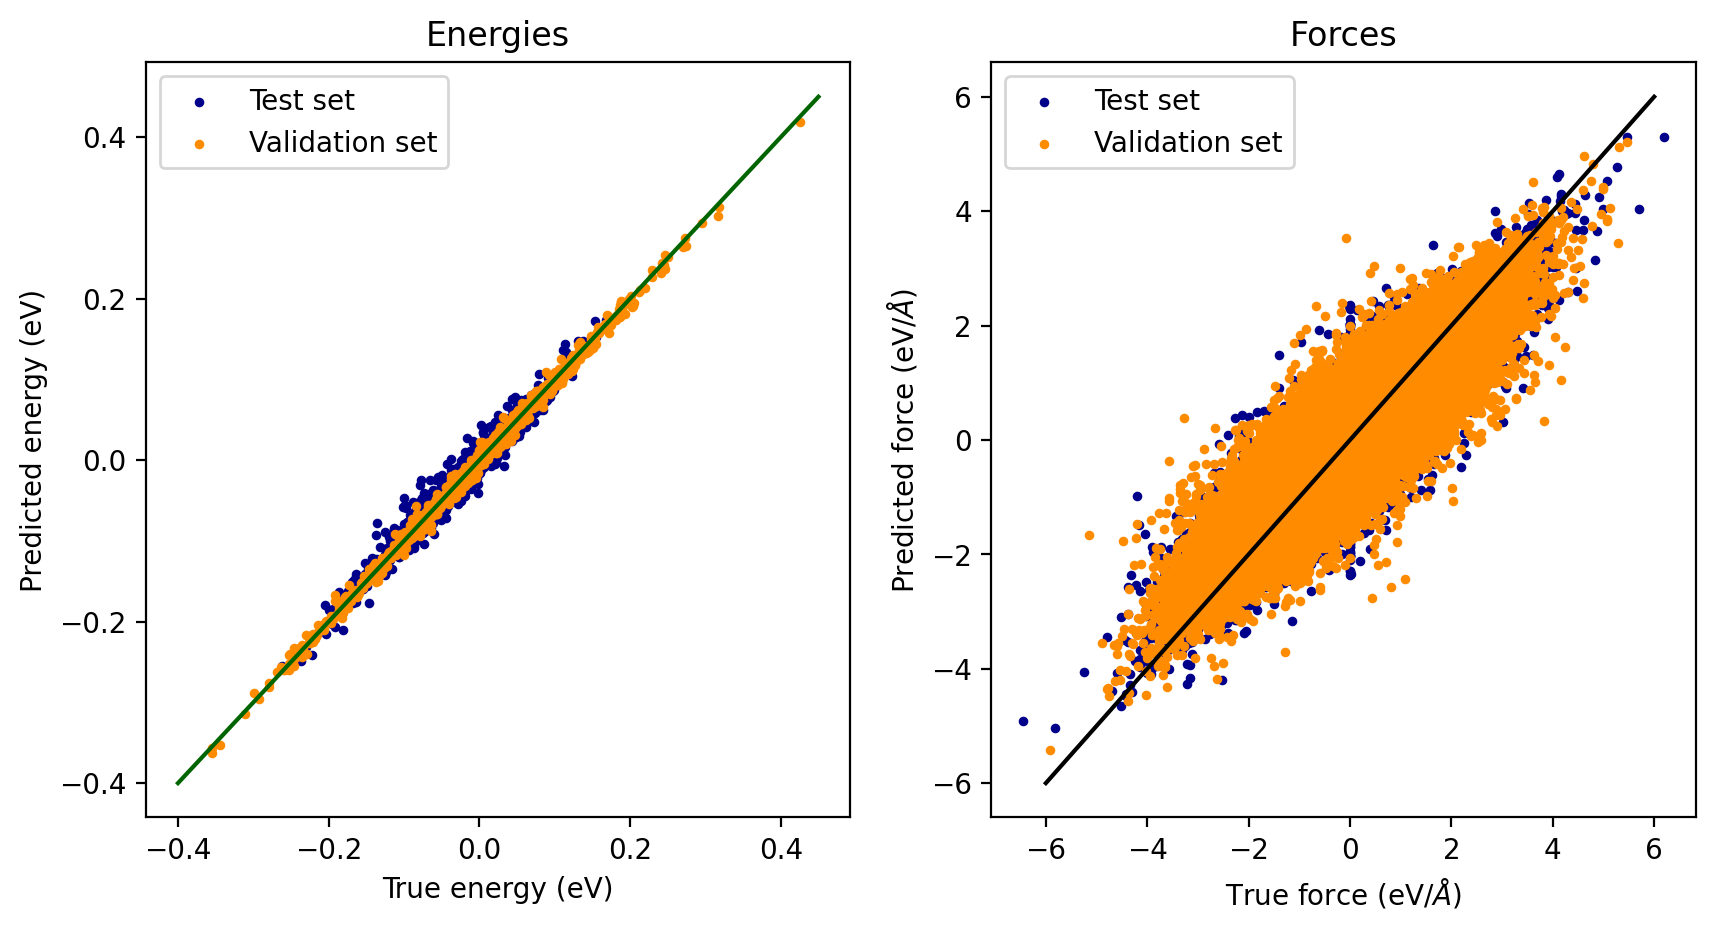

In [55]:
#Plot predicted vs. actual energies and forces
f,p = plt.subplots(1,2, figsize = (10, 5), dpi=200)
p[0].scatter((y_1k[:npred] - mlr.predict(X_1k[:npred]))/np.sum(X_1k[:npred],axis=1),
             (ytest_pred_2[:npred] - mlr.predict(X_1k[:npred]))/np.sum(X_1k[:npred],axis=1), 
             s=6, color='darkblue', alpha=1, label='Test set')
p[0].scatter((y_val[:npred] - mlr.predict(X_val[:npred]))/np.sum(X_val[:npred],axis=1),
             (yval_pred_2[:npred] - mlr.predict(X_val[:npred]))/np.sum(X_val[:npred],axis=1), 
             s=6, color='darkorange', alpha=1, label='Validation set')
p[0].set_title('Energies')
p[0].plot([-0.4,0.45], [-0.4, 0.45], color='darkgreen')
p[0].set_xlabel('True energy (eV)')
p[0].set_ylabel('Predicted energy (eV)')
p[0].legend()
p[1].scatter(f_1k.flatten(), ftest_pred_2.flatten(), s=6, color='darkblue', alpha=1, label='Test set')
p[1].scatter(f_val.flatten(), fval_pred_2.flatten(), s=6, color='darkorange', alpha=1, label='Validation set')
p[1].plot([-6,6], [-6, 6], color='black')
p[1].set_title(r'Forces')
p[1].set_xlabel('True force (eV/$\AA$)')
p[1].set_ylabel('Predicted force (eV/$\AA$)')
p[1].legend()
plt.savefig('figures/direct_model_test_val_set_comparison_full_GAP_model_FPS_0.055_3.25.png')